<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/dataloader_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

with open('/content/drive/My Drive/Colab Notebooks/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)

trainX = np.concatenate((X1, X2))

with open('/content/drive/My Drive/Colab Notebooks/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)



In [4]:
class_weights = {}
for c in range(3):
  class_weights[c] = 1000/np.sum(train_y==c)
  print(class_weights[c])


0.12553351744915892
0.183452577508714
4.484304932735426


In [10]:
tf.__version__


'2.2.0-rc3'

In [0]:
N = trainX.shape[0]
testN = testX.shape[0]

trainX = trainX.reshape((N, 224, 224, 1))
testX = testX.reshape((testN, 224, 224, 1))

In [6]:
test_y.shape


(1510,)

In [7]:
model = keras.models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(trainX, train_y, epochs=10, 
                    validation_data=(testX, test_y))

Epoch 1/10
427/427 [==============================] - 355s 830ms/step - loss: 0.5071 - accuracy: 0.7947 - val_loss: 0.4001 - val_accuracy: 0.8490
Epoch 2/10
427/427 [==============================] - 354s 830ms/step - loss: 0.4094 - accuracy: 0.8470 - val_loss: 0.3750 - val_accuracy: 0.8483
Epoch 3/10
427/427 [==============================] - 346s 809ms/step - loss: 0.3835 - accuracy: 0.8567 - val_loss: 0.3591 - val_accuracy: 0.8728
Epoch 4/10
427/427 [==============================] - 345s 809ms/step - loss: 0.3459 - accuracy: 0.8726 - val_loss: 0.3650 - val_accuracy: 0.8642
Epoch 5/10
427/427 [==============================] - 339s 794ms/step - loss: 0.3177 - accuracy: 0.8806 - val_loss: 0.2931 - val_accuracy: 0.8927
Epoch 6/10
427/427 [==============================] - 346s 809ms/step - loss: 0.2987 - accuracy: 0.8886 - val_loss: 0.2950 - val_accuracy: 0.8914
Epoch 7/10
427/427 [==============================] - 355s 832ms/step - loss: 0.2752 - accuracy: 0.8977 - val_loss: 0.2866 -

48/48 - 10s - loss: 0.2905 - accuracy: 0.9013


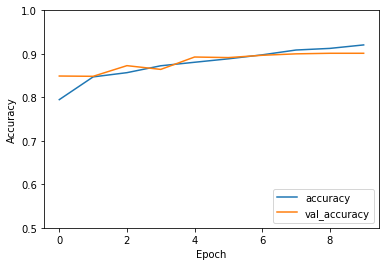

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testX,  test_y, verbose=2)

In [0]:
trainY = np.zeros((N, 3))
testY = np.zeros((testN, 3))

trainY[np.arange(N), train_y] = 1
testY[np.arange(testN), test_y] = 1


In [9]:
testY.shape

(1510, 3)

In [8]:
metrics = [
           keras.metrics.Accuracy(),
           keras.metrics.Precision(),
           keras.metrics.Recall()
           ]

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


history = model.fit(trainX, train_y, epochs=10, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))

Epoch 1/10
427/427 [==============================] - 360s 844ms/step - loss: 0.1917 - accuracy: 0.6545 - val_loss: 0.6316 - val_accuracy: 0.7530
Epoch 2/10
427/427 [==============================] - 359s 841ms/step - loss: 0.1500 - accuracy: 0.7599 - val_loss: 0.7745 - val_accuracy: 0.6841
Epoch 3/10
427/427 [==============================] - 362s 849ms/step - loss: 0.1251 - accuracy: 0.7826 - val_loss: 0.5208 - val_accuracy: 0.8060
Epoch 4/10
427/427 [==============================] - 359s 841ms/step - loss: 0.1148 - accuracy: 0.7957 - val_loss: 0.5859 - val_accuracy: 0.7821
Epoch 5/10
427/427 [==============================] - 358s 839ms/step - loss: 0.1004 - accuracy: 0.8110 - val_loss: 0.5291 - val_accuracy: 0.8020
Epoch 6/10
427/427 [==============================] - 356s 834ms/step - loss: 0.0964 - accuracy: 0.8169 - val_loss: 0.4635 - val_accuracy: 0.8146
Epoch 7/10
427/427 [==============================] - 356s 834ms/step - loss: 0.0803 - accuracy: 0.8389 - val_loss: 0.3506 -

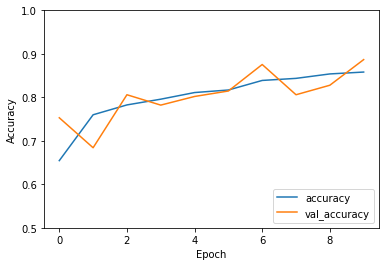

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


Epoch 1/10
427/427 [==============================] - 359s 842ms/step - loss: 0.2997 - accuracy: 0.8897 - val_loss: 0.2971 - val_accuracy: 0.8881
Epoch 2/10
427/427 [==============================] - 360s 843ms/step - loss: 0.2551 - accuracy: 0.9045 - val_loss: 0.2911 - val_accuracy: 0.8993
Epoch 3/10
427/427 [==============================] - 358s 839ms/step - loss: 0.2338 - accuracy: 0.9138 - val_loss: 0.3136 - val_accuracy: 0.8980
Epoch 4/10
427/427 [==============================] - 364s 852ms/step - loss: 0.2207 - accuracy: 0.9216 - val_loss: 0.3816 - val_accuracy: 0.8709
Epoch 5/10
427/427 [==============================] - 360s 843ms/step - loss: 0.1870 - accuracy: 0.9323 - val_loss: 0.3806 - val_accuracy: 0.8901
Epoch 6/10
427/427 [==============================] - 361s 846ms/step - loss: 0.1745 - accuracy: 0.9370 - val_loss: 0.4025 - val_accuracy: 0.8775
Epoch 7/10
427/427 [==============================] - 360s 844ms/step - loss: 0.1568 - accuracy: 0.9433 - val_loss: 0.3534 -

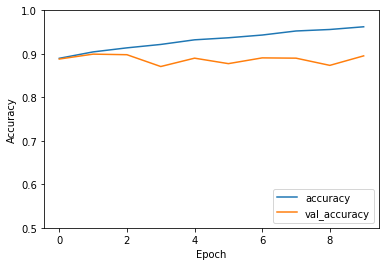

In [10]:
class_weights = {}
class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 4

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(trainX, train_y, epochs=10, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(testX, test_y))  

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
